In [360]:
import numpy as np
import time
import math
import itertools
import scipy.spatial.distance as sp
from scipy.ndimage.interpolation import shift
from scipy.ndimage.filters import gaussian_filter
from skimage import data, transform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.datasets.mldata import fetch_mldata
import matplotlib.pyplot as plt

In [361]:
def calculate_distance_euclidean(X, Y):
    return np.sqrt((-(2 * X.dot(Y.T))) + (X ** 2).sum(axis=1)[:, np.newaxis] + (Y.T ** 2).sum(axis=0)[np.newaxis, :])

In [362]:
def calculate_distance_cosine(X, Y):
    return 1 - X.dot(Y.T) / np.sqrt(((X ** 2).sum(axis = 1)[:, np.newaxis]) * ((Y.T ** 2).sum(axis=0)[np.newaxis, :]))

In [363]:
class KNNClassifier:
    def __init__(self, k, strategy='my_own', metric='euclidean', weights=False, test_block_size=0):
        self.k = k
        if strategy == 'my_own':
            self.strategy = 'my_own'
        elif strategy == 'brute':
            self.strategy = 'brute'
        elif strategy == 'kd_tree':
            self.strategy = 'kd_tree'
        elif strategy == 'ball_tree':
            self.strategy = 'ball_tree'
        else:
            raise TypeError('Unknown strategy type')
        if metric == 'euclidean':
            self.metric = 'euclidean'
            self.metric_function = calculate_distance_euclidean
        elif metric == 'cosine':
            self.metric = 'cosine'
            self.metric_function = calculate_distance_cosine
        else:
            raise TypeError('Unknown metric type')
        if weights == True or weights == False:
            self.weights = weights
        else: 
            raise TypeError('Incorrect weights value')
        self.test_block_size = test_block_size
            
    def fit(self, X, y):
        if self.strategy == 'my_own':
            self.X = X
            self.y = y
        else:
            self.y = y
            self.neighbors_class = NearestNeighbors(self.k, algorithm=self.strategy, metric=self.metric)
            self.neighbors_class.fit(X, y)
    
    def find_kneighbors(self, X, return_distance=True):
        if self.strategy == 'my_own':
            if self.test_block_size == 0:
                distance = self.metric_function(self.X, X)
                index = np.argpartition(distance, range(self.k), axis=0)[:self.k:]
                distance = distance[index, np.arange(distance.shape[1])]
                if return_distance == True:
                    return tuple([distance.T, index.T])
                else:
                    return index.T
            else:
                ind = np.empty((0, self.k))
                dist = np.empty((0, self.k))
                for i in range(X.shape[0] // self.test_block_size):
                    distance = self.metric_function(self.X, X[i * self.test_block_size:(i + 1) * self.test_block_size:])
                    index = np.argpartition(distance, range(self.k), axis=0)[:self.k:]
                    distance = distance[index, np.arange(distance.shape[1])]
                    ind = np.vstack((ind, index.T))
                    dist = np.vstack((dist, distance.T))    
                if X.shape[0] % self.test_block_size != 0:
                    distance = self.metric_function(self.X, X[(X.shape[0] // self.test_block_size) * self.test_block_size:])
                    index = np.argpartition(distance, range(self.k), axis=0)[:self.k:]
                    distance = distance[index, np.arange(distance.shape[1])]
                    ind = np.vstack((ind, index.T))
                    dist = np.vstack((dist, distance.T))
                if return_distance == True:
                    return tuple([dist, ind.astype(int)])
                else:
                    return ind.astype(int)
        else:
            if self.test_block_size == 0:
                return self.neighbors_class.kneighbors(X, self.k, return_distance=return_distance)
            else:
                ind = np.empty((0, self.k))
                dist = np.empty((0, self.k))
                for i in range(X.shape[0] // self.test_block_size):
                    distance, index = self.neighbors_class.kneighbors(X[i * self.test_block_size:(i + 1) * self.test_block_size:], self.k, return_distance=True)
                    ind = np.vstack((ind, index))
                    dist = np.vstack((dist, distance))
                if X.shape[0] % self.test_block_size != 0:
                    distance, index = self.neighbors_class.kneighbors(X[(X.shape[0] // self.test_block_size) * self.test_block_size:], self.k, return_distance=True)
                    ind = np.vstack((ind, index))
                    dist = np.vstack((dist, distance))
                if return_distance == True:
                    return tuple([dist, ind.astype(int)])
                else:
                    return ind.astype(int)
    
    def predict(self, X):
        if self.weights == True:
            dist, ind = self.find_kneighbors(X)
            ind = self.y[ind]
            weights = 1 / (10 ** (-5) + dist)
            res = np.zeros(ind.shape[0])
            max_dist = np.zeros(ind.shape[0])
            for i in np.unique(self.y):
                mask = ind == i
                temp = (mask * weights).sum(axis=1)
                res[max_dist < temp] = i
                max_dist = np.maximum(max_dist, temp)
            return res.astype(int)
        else:
            ind = self.find_kneighbors(X, return_distance=False)
            ind = self.y[ind]
            res = np.zeros(ind.shape[0]) 
            max_dist = np.zeros(ind.shape[0])
            for i in np.unique(self.y):
                mask = ind == i
                temp = mask.sum(axis=1)
                res[max_dist < temp] = i
                max_dist = np.maximum(max_dist, temp)
            return res.astype(int)
        
    def predict_mod(self, X, func):
        dist, ind = self.find_kneighbors(X)
        for f in func:
            for i in f[1]:
                X_new = np.array([f[0](elem.reshape(28, 28), i).ravel() for elem in X])
                distance, index = self.find_kneighbors(X_new)
                dist = np.hstack((dist, distance))
                ind = np.hstack((ind, index))
                del distance, index, X_new
        indices = np.argpartition(dist, range(self.k), axis=1)[:, :self.k:]
        dist = dist[np.arange(dist.shape[0])[:, np.newaxis], indices]
        ind = ind[np.arange(dist.shape[0])[:, np.newaxis], indices]
        ind = self.y[ind]
        if self.weights is True:
            weights = 1 / (10 ** (-5) + dist)
        else:
            dist = 1
            weights = dist
        res = np.zeros(ind.shape[0])
        max_dist = np.zeros(ind.shape[0])
        for i in np.unique(self.y):
            mask = ind == i
            temp = (mask * weights).sum(axis=1)
            res[max_dist < temp] = i
            max_dist = np.maximum(max_dist, temp)
        return res.astype(int)

In [364]:
def kfold(n, n_folds):
    arr = np.arange(n)
    np.random.shuffle(arr)
    arr_list = np.array_split(arr, n_folds)
    res = []
    for i in range(n_folds):
        indices = arr_list.copy()
        val = indices.pop(i)
        train = np.hstack(indices)
        res.append((train, val))
    return res

def cross_val_predict(ind, dist, classes, weights):
        if weights is True:
            weights = 1 / (10 ** (-5) + dist)
        else:
            weights = np.ones(ind.shape)
        res = np.zeros(ind.shape[0]) 
        max_dist = np.zeros(ind.shape[0])
        for i in classes:
            mask = ind == i
            temp = (mask * weights).sum(axis=1)
            res[max_dist < temp] = i
            max_dist = np.maximum(max_dist, temp)
        return res.astype(int)
            

def knn_cross_val_score(X, y, k_list, score='accuracy', cv=3, **kwargs):
    if cv == None:
        cv = kfold(len(X), 3)
    elif type(cv) == int:
        cv = kfold(len(X), cv)
    if score != 'accuracy':
        raise TypeError('Unknown score type')
    k_list.sort()
    res = {}
    for k in k_list:
        res[k] = []
    cl = KNNClassifier(k=max(k_list), **kwargs)
    for i in range(len(cv)):
        cl.fit(X[cv[i][0]], y[cv[i][0]])
        dist, ind = cl.find_kneighbors(X[cv[i][1]], return_distance=True)
        for k in k_list:
            pred = cross_val_predict(y[cv[i][0]][ind][::, :k:], dist[::, :k:], np.unique(y[cv[i][0]]), weights=cl.weights)
            res[k].append((pred == y[cv[i][1]]).sum() / len(y[cv[i][1]]))
    return res

def cross_val_score_mod(X, y, k_list, params, func, score='accuracy', cv=3, **kwargs):
    if cv == None:
        cv = kfold(len(X), 3)
    elif type(cv) == int:
        cv = kfold(len(X), cv)
    if score != 'accuracy':
        raise TypeError('Unknown score type')
    k_list.sort()
    res = {}
    for k in k_list:
        res[k] = []
    cl = KNNClassifier(k=max(k_list), metric='cosine', strategy='brute', test_block_size=500, weights=True)
    for i in range(len(cv)):
        X_temp = X[cv[i][0]]
        y_temp = y[cv[i][0]]
        X_t = X[cv[i][1]]
        y_t = y[cv[i][1]]
        cl.fit(X_temp, y_temp)
        dist, ind = cl.find_kneighbors(X_t, return_distance=True)
        for arg in params:
            X_new = np.array([func(elem.reshape(28, 28), arg).ravel() for elem in X_temp])
            cl.fit(X_new, y_temp)
            distance, index = cl.find_kneighbors(X_t, return_distance=True)
            dist = np.hstack((dist, distance))
            ind = np.hstack((ind, index))
            del distance, index, X_new
        indices = np.argpartition(dist, range(max(k_list)), axis=1)[:, :max(k_list):]
        dist = dist[np.arange(dist.shape[0])[:, np.newaxis], indices]
        ind = ind[np.arange(dist.shape[0])[:, np.newaxis], indices]
        for k in k_list:
            pred = cross_val_predict(y_temp[ind][::, :k:], dist[::, :k:], np.unique(y_temp), weights=cl.weights)
            res[k].append((pred == y_t).sum() / len(y_t))
        del dist, ind, X_temp, y_temp, X_t, y_t 
    return res

def cross_val_score_mod_test(X, y, k_list, params, func, score='accuracy', cv=3, **kwargs):
    if cv == None:
        cv = kfold(len(X), 3)
    elif type(cv) == int:
        cv = kfold(len(X), cv)
    if score != 'accuracy':
        raise TypeError('Unknown score type')
    k_list.sort()
    res = {}
    for k in k_list:
        res[k] = []
    cl = KNNClassifier(k=max(k_list), metric='cosine', strategy='brute', test_block_size=500, weights=True)
    for i in range(len(cv)):
        X_temp = X[cv[i][0]]
        y_temp = y[cv[i][0]]
        X_t = X[cv[i][1]]
        y_t = y[cv[i][1]]
        cl.fit(X_temp, y_temp)
        dist, ind = cl.find_kneighbors(X_t, return_distance=True)
        for arg in params:
            X_new = np.array([func(elem.reshape(28, 28), arg).ravel() for elem in X_t])
            distance, index = cl.find_kneighbors(X_new, return_distance=True)
            dist = np.hstack((dist, distance))
            ind = np.hstack((ind, index))
            del distance, index, X_new
        indices = np.argpartition(dist, range(max(k_list)), axis=1)[:, :max(k_list):]
        dist = dist[np.arange(dist.shape[0])[:, np.newaxis], indices]
        ind = ind[np.arange(dist.shape[0])[:, np.newaxis], indices]
        for k in k_list:
            pred = cross_val_predict(y_temp[ind][::, :k:], dist[::, :k:], np.unique(y_temp), weights=cl.weights)
            res[k].append((pred == y_t).sum() / len(y_t))
        del dist, ind, X_temp, y_temp, X_t, y_t 
    return res

In [421]:
#функция взята из http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [366]:
mnist = fetch_mldata("MNIST original")

In [367]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size = 10000, shuffle=False)

In [368]:
X_train = X_train.astype(np.int32)
X_test = X_test.astype(np.int32)

In [369]:
strategies = ['my_own', 'brute', 'kd_tree', 'ball_tree']
amm_features = [10, 20, 100]
features = []
times = {}
for amm in amm_features:
    features.append(np.random.choice(X_train.shape[1], amm))
for st in strategies:
    cl = KNNClassifier(5, strategy=st, test_block_size=500)
    times[st] = []
    for f in features:
        X_1 = X_train[::, f]
        X_2 = X_test[::, f]
        cl.fit(X_1, y_train)
        start = time.time()
        neig = cl.find_kneighbors(X_2, return_distance=False)
        times[st].append(time.time() - start)
times

{'ball_tree': [10.755736827850342, 34.84365200996399, 132.67339611053467],
 'brute': [13.947761058807373, 14.306493759155273, 15.251935958862305],
 'kd_tree': [1.020373821258545, 7.153217077255249, 97.58389401435852],
 'my_own': [41.18622708320618, 44.71323895454407, 82.41157627105713]}

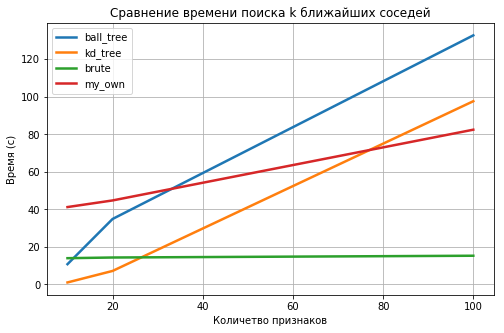

In [419]:
features = [10, 20, 100]
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(features, times['ball_tree'], label=u"ball_tree", linewidth=2.5)
ax.plot(features, times['kd_tree'], label=u"kd_tree", linewidth=2.5)
ax.plot(features, times['brute'], label=u"brute", linewidth=2.5)
ax.plot(features, times['my_own'], label=u"my_own", linewidth=2.5)
ax.set_title(u"Сравнение времени поиска k ближайших соседей")
ax.set_xlabel(u"Количетво признаков")
ax.set_ylabel(u"Время (с)")
ax.grid()
ax.legend()
plt.savefig("times_strategies.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [371]:
start = time.time()
scores_euc = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=3, strategy='brute', test_block_size=2000)
scores_euc['time'] = time.time() -  start
start = time.time()
scores_cosine = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=3, metric='cosine', strategy='brute', test_block_size=2000)
scores_cosine['time'] = time.time() -  start

In [372]:
for i in scores_euc:
    scores_euc[i] = np.mean(scores_euc[i])
for i in scores_cosine:
    scores_cosine[i] = np.mean(scores_cosine[i])
scores_euc, scores_cosine

({1: 0.9700333333333333,
  2: 0.96278333333333332,
  3: 0.96939999999999993,
  4: 0.96799999999999997,
  5: 0.96824999999999994,
  6: 0.96733333333333338,
  7: 0.9671333333333334,
  8: 0.96565000000000001,
  9: 0.96488333333333343,
  10: 0.96456666666666668,
  'time': 98.483994007110596},
 {1: 0.97336666666666671,
  2: 0.96899999999999997,
  3: 0.97356666666666669,
  4: 0.97263333333333335,
  5: 0.97275,
  6: 0.97193333333333332,
  7: 0.97143333333333326,
  8: 0.97041666666666659,
  9: 0.97023333333333339,
  10: 0.96973333333333345,
  'time': 108.14720892906189})

In [373]:
start = time.time()
scores_euc_w = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=3, strategy='brute', weights=True, test_block_size=2000)
scores_euc_w['time'] = time.time() -  start
start = time.time()
scores_cosine_w = knn_cross_val_score(X_train, y_train, k_list=list(range(1, 11)), cv=3, metric='cosine', weights=True, strategy='brute', test_block_size=2000)
scores_cosine_w['time'] = time.time() -  start

In [374]:
for i in scores_euc_w:
    scores_euc_w[i] = np.mean(scores_euc_w[i])
for i in scores_cosine_w:
    scores_cosine_w[i] = np.mean(scores_cosine_w[i])
scores_euc_w, scores_cosine_w

({1: 0.96975,
  2: 0.96975,
  3: 0.9703666666666666,
  4: 0.97184999999999999,
  5: 0.97038333333333338,
  6: 0.97050000000000003,
  7: 0.96801666666666664,
  8: 0.96871666666666678,
  9: 0.96673333333333333,
  10: 0.96663333333333334,
  'time': 102.84778761863708},
 {1: 0.97426666666666673,
  2: 0.97426666666666673,
  3: 0.97491666666666665,
  4: 0.97526666666666673,
  5: 0.97361666666666669,
  6: 0.97418333333333329,
  7: 0.97215000000000007,
  8: 0.97276666666666667,
  9: 0.97141666666666671,
  10: 0.9714666666666667,
  'time': 111.3391170501709})

In [375]:
cos_3 = KNNClassifier(3, strategy='brute', metric='cosine', test_block_size=500)
cos_w_4 = KNNClassifier(4, strategy='brute', metric='cosine', weights=True, test_block_size=500)
euc_w_4 = KNNClassifier(4, strategy='brute', weights=True, test_block_size=500)
cos_3.fit(X_train, y_train)
cos_w_4.fit(X_train, y_train)
euc_w_4.fit(X_train, y_train)
pred = []
pred.append(cos_3.predict(X_test))
pred.append(cos_w_4.predict(X_test))
pred.append(euc_w_4.predict(X_test))

In [376]:
accuracy = []
for i in pred:
    accuracy.append((i == y_test).sum() / len(y_test))
accuracy

[0.97330000000000005, 0.97519999999999996, 0.97140000000000004]

Ammount of misses:  248
Accuracy: 0.97520
Confusion matrix, without normalization
[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    0 1009    1    1    0    0    8    5    0]
 [   0    1    3  976    1   12    0    4    9    4]
 [   2    1    0    0  946    0    6    2    0   25]
 [   4    0    0    9    1  863    7    1    4    3]
 [   3    3    0    0    1    3  948    0    0    0]
 [   2   10    4    0    1    0    0  998    0   13]
 [   7    1    2    9    3    3    5    4  936    4]
 [   7    7    2    5    7    3    1    4    3  970]]


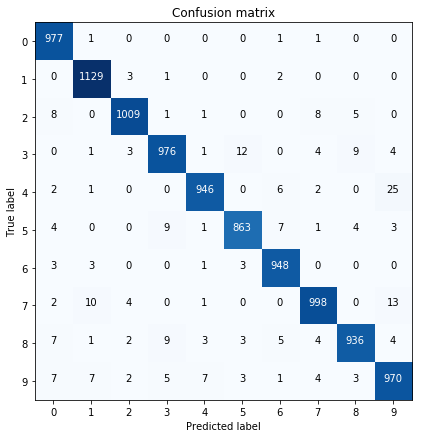

In [435]:
cm = confusion_matrix(pred[1], y_test)
cm
accuracy_not_mod = accuracy[1]
cm = confusion_matrix(y_test, pred[1])
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_not_mod)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix')
plt.savefig("cm.pdf", format='pdf', bbox_inches='tight')
plt.show()

[7 8 0 9 2 9 6 6 9 7]


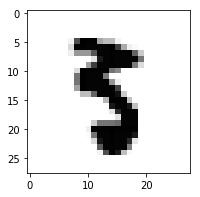

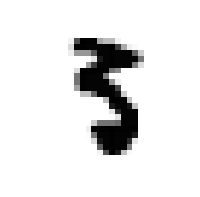

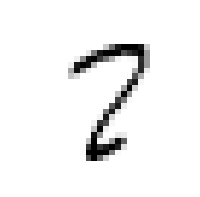

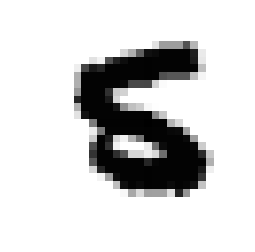

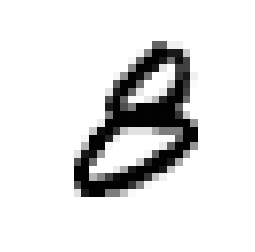

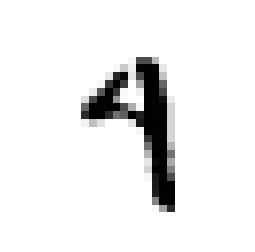

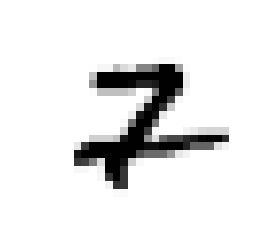

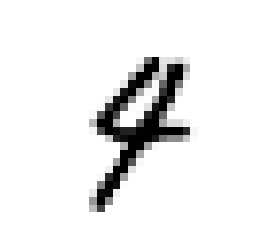

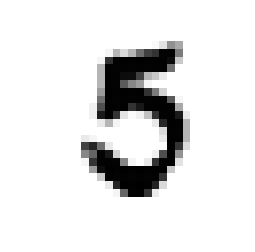

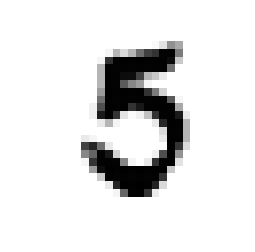

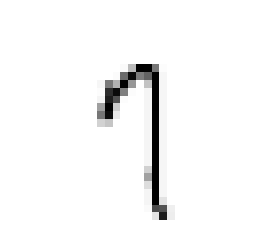

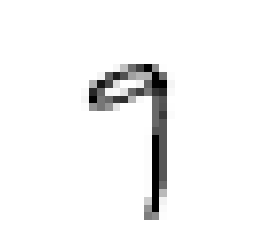

In [445]:
misses = np.arange(len(y_test))[pred[1] != y_test]
subset = np.random.choice(len(misses), 10)
print(pred[1][misses[subset]])
imgs = X_test[misses[subset]]
for elem in imgs:
    plt.axis('off')
    plt.imshow(elem.reshape(28, 28), cmap='Greys')
    plt.show()

In [379]:
rot_scores = {}
for i in [(-15, 15), (-10, 10), (-5, 5)]:
    scores = cross_val_score_mod(X_train, y_train, params=i, k_list=[4], cv=3, func=transform.rotate)
    for index in scores:
        scores[index] = np.mean(scores[index])
    rot_scores[i] = scores[4]
rot_scores

{(-15, 15): 0.97926666666666673,
 (-10, 10): 0.98096666666666665,
 (-5, 5): 0.98019999999999996}

In [380]:
sh_scores = {}
for i in [[(-3, 0), (3, 0), (0, -3), (0, 3)], [(-2, 0), (2, 0), (0, -2), (0, 2)], [(-1, 0), (1, 0), (0, -1), (0, 1)]]:
    scores = cross_val_score_mod(X_train, y_train, params=i, k_list=[4], cv=3, func=shift)
    for index in scores:
        scores[index] = np.mean(scores[index])
    sh_scores[i[1][0]] = scores[4]
sh_scores

{1: 0.98198333333333343, 2: 0.97853333333333337, 3: 0.97624999999999995}

In [381]:
fl_scores = {}
for i in [[math.sqrt(0.5)], [math.sqrt(1.0)], [math.sqrt(1.5)]]:
    scores = cross_val_score_mod(X_train, y_train, k_list=[4], cv=3, func=gaussian_filter, params=i)
    for index in scores:
        scores[index] = np.mean(scores[index])
    fl_scores[i[0]] = scores[4]
fl_scores

{0.7071067811865476: 0.97923333333333329,
 1.0: 0.97973333333333334,
 1.224744871391589: 0.98050000000000004}

In [401]:
rotated_imgs = []
for i in X_train:
    rotated_imgs.append(transform.rotate(i.reshape(28, 28), -10))
rotated_imgs = np.array(rotated_imgs).reshape(len(rotated_imgs), 784)
X_new = np.vstack((X_train, rotated_imgs))
rotated_imgs = []
for i in X_train:
    rotated_imgs.append(transform.rotate(i.reshape(28, 28), 10))
rotated_imgs = np.array(rotated_imgs).reshape(len(rotated_imgs), 784)
X_new = np.vstack((X_new, rotated_imgs))
y_new = np.hstack((y_train, y_train, y_train))
cos_w_4.fit(X_new, y_new)
pred_rot = cos_w_4.predict(X_test)

Ammount of misses:  188
Accuracy: 0.98120
Confusion matrix, without normalization
[[ 976    1    0    0    0    0    2    1    0    0]
 [   0 1132    2    0    0    0    0    1    0    0]
 [   6    2 1008    2    1    0    1   10    2    0]
 [   0    0    1  986    1    7    0    3    7    5]
 [   1    0    0    0  951    0    5    2    0   23]
 [   3    0    0    6    1  874    3    2    1    2]
 [   2    3    0    0    0    1  951    0    1    0]
 [   2    7    3    0    0    0    0 1008    0    8]
 [   2    0    3    5    4    3    2    3  947    5]
 [   4    4    1    5    5    2    1    5    3  979]]


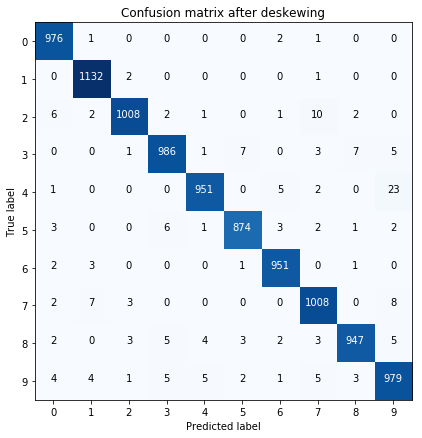

In [436]:
accuracy_rot = (pred_rot == y_test).sum() / len(y_test)
cm = confusion_matrix(y_test, pred_rot)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_rot)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after deskewing')
plt.savefig("cm_desk.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [403]:
X_new = X_train
y_new = y_train
for i in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
    shifted_imgs = []
    shifted_imgs = np.array([shift(elem.reshape(28, 28), shift=i).ravel() for elem in X_train])
    X_new = np.vstack((X_new, shifted_imgs))
    y_new = np.hstack((y_new, y_train))
cos_w_4.fit(X_new, y_new)
pred_sh = cos_w_4.predict(X_test)

Ammount of misses:  202
Accuracy: 0.97980
Confusion matrix, without normalization
[[ 977    0    0    0    0    0    2    1    0    0]
 [   0 1132    3    0    0    0    0    0    0    0]
 [   8    0 1011    1    0    0    2    9    1    0]
 [   1    0    1  988    0    7    0    5    6    2]
 [   1    1    0    0  951    0    5    0    1   23]
 [   3    0    0   10    1  861    6    2    6    3]
 [   3    2    0    0    0    2  951    0    0    0]
 [   2    8    4    0    2    0    0 1002    0   10]
 [   3    0    2    6    1    4    5    4  945    4]
 [   6    6    1    3    4    3    0    4    2  980]]


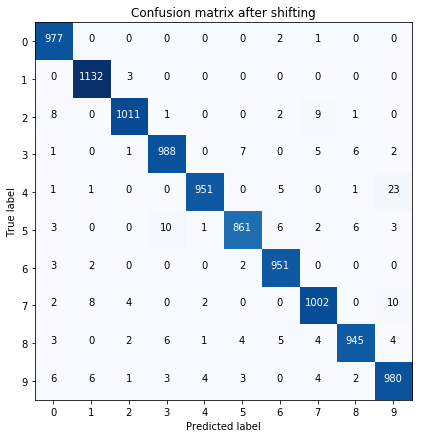

In [455]:
accuracy_sh = (pred_sh == y_test).sum() / len(y_test)
cm = confusion_matrix(y_test, pred_sh)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_sh)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after shifting')
plt.savefig("cm_sh.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [405]:
filtered_imgs = []
for i in X_train:
    filtered_imgs.append(gaussian_filter(i.reshape(28, 28), sigma=math.sqrt(1.5)))
filtered_imgs = np.array(filtered_imgs).reshape(len(filtered_imgs), 784)
X_new = np.vstack((X_train, filtered_imgs))
y_new = np.append(y_train, y_train)
cos_w_4.fit(X_new, y_new)
pred_fl = cos_w_4.predict(X_test)

Ammount of misses:  192
Accuracy: 0.98080
Confusion matrix, without normalization
[[ 976    1    0    0    0    0    1    2    0    0]
 [   0 1130    3    0    0    0    2    0    0    0]
 [   6    1 1005    2    1    0    1   13    3    0]
 [   0    0    1  987    1    9    0    4    4    4]
 [   0    0    0    0  961    0    4    2    0   15]
 [   2    1    0    6    1  872    4    1    2    3]
 [   3    3    0    0    1    3  948    0    0    0]
 [   0    7    6    2    3    1    0 1000    0    9]
 [   3    0    1    4    3    3    5    4  946    5]
 [   2    4    0    2    8    2    0    6    2  983]]


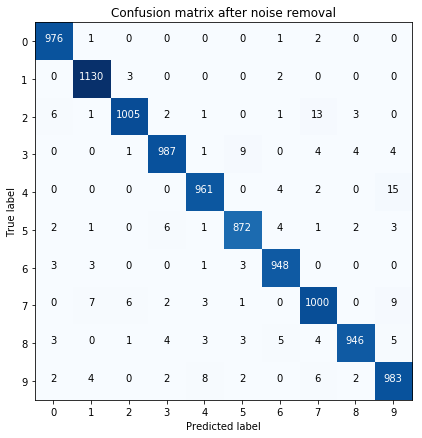

In [449]:
accuracy_fl = (pred_fl == y_test).sum() / len(y_test)
cm = confusion_matrix(y_test, pred_fl)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_fl)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after noise removal')
plt.savefig("cm_desk.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [407]:
cos_w_4 = KNNClassifier(4, strategy='brute', metric='cosine', weights=True, test_block_size=250)
X_new = X_train
y_new = y_train
for i in [-10, 10]:
    X_rot = np.array([transform.rotate(elem.reshape(28, 28), angle=i).ravel() for elem in X_train])
    X_new = np.vstack((X_new, X_rot))
    y_new = np.hstack((y_new, y_train))
for i in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
    X_sh = np.array([shift(elem.reshape(28, 28), shift=i).ravel() for elem in X_train])
    X_new = np.vstack((X_new, X_sh))
    y_new = np.hstack((y_new, y_train))
X_fl = np.array([gaussian_filter(elem.reshape(28, 28), sigma=math.sqrt(1.5)).ravel() for elem in X_train])
X_new = np.vstack((X_new, X_fl))
y_new = np.hstack((y_new, y_train))
cos_w_4.fit(X_new, y_new)
pred_fin = cos_w_4.predict(X_test)

Ammount of misses:  150
Accuracy: 0.98500
Confusion matrix, without normalization
[[ 975    0    0    0    0    0    3    2    0    0]
 [   0 1132    3    0    0    0    0    0    0    0]
 [   5    2 1012    0    1    0    2   10    0    0]
 [   0    0    1  993    1    4    0    3    4    4]
 [   0    0    0    0  963    0    4    2    0   13]
 [   2    0    0    5    1  875    6    1    0    2]
 [   2    2    0    0    0    1  953    0    0    0]
 [   1    6    3    2    0    0    0 1010    0    6]
 [   2    0    3    2    2    3    5    4  950    3]
 [   2    3    0    4    4    2    0    4    3  987]]


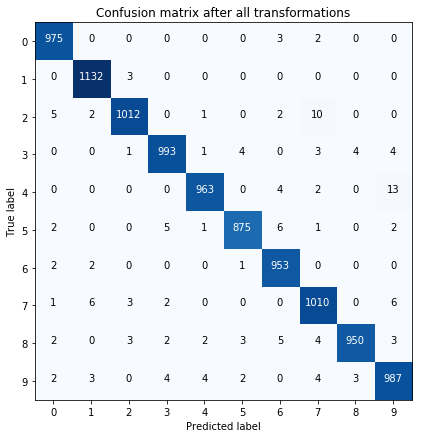

In [450]:
accuracy_fin = (pred_fin == y_test).sum() / len(y_test)
cm = confusion_matrix(y_test, pred_fin)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_fin)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after all transformations')
plt.savefig("cm_fin.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [390]:
rot_scores_test = {}
for i in [(-15, 15), (-10, 10), (-5, 5)]:
    scores = cross_val_score_mod_test(X_train, y_train, params=i, k_list=[4], cv=3, func=transform.rotate)
    for index in scores:
        scores[index] = np.mean(scores[index])
    rot_scores_test[i] = scores[4]
rot_scores_test

{(-15, 15): 0.97575000000000001,
 (-10, 10): 0.97775000000000001,
 (-5, 5): 0.97846666666666671}

In [391]:
fl_scores_test = {}
for i in [[math.sqrt(0.5)], [math.sqrt(1.0)], [math.sqrt(1.5)]]:
    scores = cross_val_score_mod_test(X_train, y_train, params=i, k_list=[4], cv=3, func=gaussian_filter)
    for index in scores:
        scores[index] = np.mean(scores[index])
    fl_scores_test[i[0]] = scores[4]
fl_scores_test

{0.7071067811865476: 0.97196666666666653,
 1.0: 0.9634166666666667,
 1.224744871391589: 0.94993333333333341}

In [392]:
sh_scores_test = {}
for i in [[(-3, 0), (3, 0), (0, -3), (0, 3)], [(-2, 0), (2, 0), (0, -2), (0, 2)], [(-1, 0), (1, 0), (0, -1), (0, 1)]]:
    scores = cross_val_score_mod(X_train, y_train, params=i, k_list=[4], cv=3, func=shift)
    for index in scores:
        scores[index] = np.mean(scores[index])
    sh_scores_test[i[1][0]] = scores[4]
sh_scores_test

{1: 0.98170000000000002, 2: 0.97836666666666672, 3: 0.97640000000000005}

In [409]:
cos_w_4 = KNNClassifier(4, strategy='brute', metric='cosine', weights=True, test_block_size=500)
cos_w_4.fit(X_train, y_train)
pred_rot_test = cos_w_4.predict_mod(X_test, [(transform.rotate, [-5, 5])])

Ammount of misses:  237
Accuracy: 0.97630
Confusion matrix, without normalization
[[ 978    0    8    0    2    2    4    3    5    5]
 [   1 1131    1    0    1    1    3    9    1    4]
 [   0    3 1008    1    0    0    0    4    2    1]
 [   0    1    0  983    0   13    0    1   12    3]
 [   0    0    1    1  946    2    1    1    4    4]
 [   0    0    0    6    0  851    1    0    2    2]
 [   0    0    1    0    6    9  948    0    4    1]
 [   1    0    9    3    3    1    0 1002    4    7]
 [   0    0    4   11    0    7    1    0  938    4]
 [   0    0    0    5   24    6    0    8    2  978]]


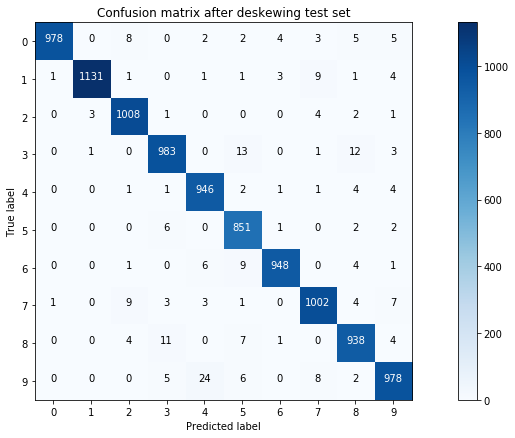

In [410]:
accuracy_rot_test = (pred_rot_test == y_test).sum() / len(y_test)
cm = confusion_matrix(pred_rot_test, y_test)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_rot_test)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after deskewing test set')
plt.show()

In [411]:
cos_w_4.fit(X_train, y_train)
pred_sh_test = cos_w_4.predict_mod(X_test, [(shift, [(1, 0), (-1, 0), (0, 1), (0, -1)])])

Ammount of misses:  202
Accuracy: 0.97980
Confusion matrix, without normalization
[[ 977    0    8    1    1    3    3    2    3    6]
 [   0 1132    0    0    1    0    2    8    0    6]
 [   0    3 1011    1    0    0    0    4    2    1]
 [   0    0    1  988    0   10    0    0    6    3]
 [   0    0    0    0  951    1    0    2    1    4]
 [   0    0    0    7    0  861    2    0    4    3]
 [   2    0    2    0    5    6  951    0    5    0]
 [   1    0    9    5    0    2    0 1002    4    4]
 [   0    0    1    6    1    6    0    0  945    2]
 [   0    0    0    2   23    3    0   10    4  980]]


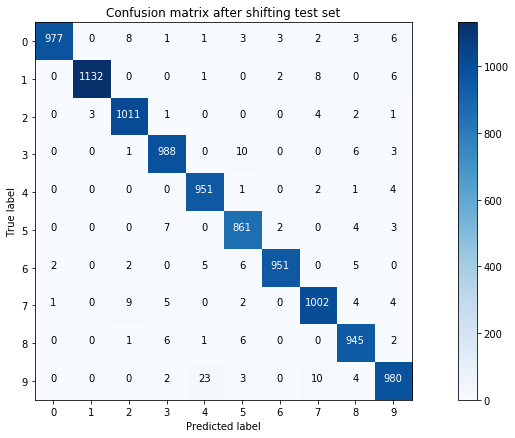

In [412]:
accuracy_sh_test = (pred_sh_test == y_test).sum() / len(y_test)
cm = confusion_matrix(pred_sh_test, y_test)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_sh_test)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after shifting test set')
plt.show()

In [413]:
cos_w_4.fit(X_train, y_train)
pred_fl_test = cos_w_4.predict_mod(X_test, [(gaussian_filter, [math.sqrt(0.5)])])

Ammount of misses:  284
Accuracy: 0.97160
Confusion matrix, without normalization
[[ 978    0    8    1    2    2    5    3    6    9]
 [   1 1129    0    1    1    2    2   13    3    8]
 [   0    3 1005    2    0    0    0    7    2    1]
 [   0    1    0  977    0   14    0    0    7    3]
 [   0    0    1    0  928    1    1    1    1    5]
 [   0    1    0    7    0  849    1    0    2    3]
 [   0    1    2    0    8    9  949    0    5    1]
 [   1    0    9    6    3    1    0  991    4    7]
 [   0    0    7   10    0   10    0    0  942    4]
 [   0    0    0    6   40    4    0   13    2  968]]


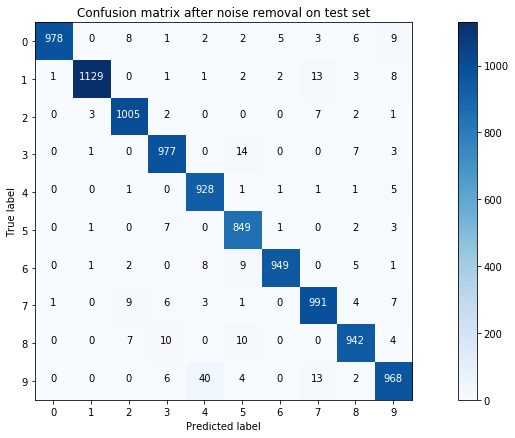

In [414]:
accuracy_fl_test = (pred_fl_test == y_test).sum() / len(y_test)
cm = confusion_matrix(pred_fl_test, y_test)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_fl_test)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after noise removal on test set')
plt.show()

In [453]:
cos_w_4.fit(X_train, y_train)
pred_fin_test = cos_w_4.predict_mod(X_test, [(transform.rotate, [-5, 5]), (shift, [(1, 0), (-1, 0), (0, 1), (0, -1)])])

Ammount of misses:  205
Accuracy: 0.97950
Confusion matrix, without normalization
[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1132    3    0    0    0    0    0    0    0]
 [   8    1 1010    0    1    0    1    9    2    0]
 [   0    0    1  987    1    4    0    3    8    6]
 [   2    1    0    0  951    0    6    2    0   20]
 [   2    1    0   11    2  857    7    1    6    5]
 [   3    2    0    0    1    1  951    0    0    0]
 [   3    5    3    1    1    0    0 1007    0    8]
 [   3    1    2    9    4    2    3    4  944    2]
 [   3    4    1    2    5    4    1    8    4  977]]


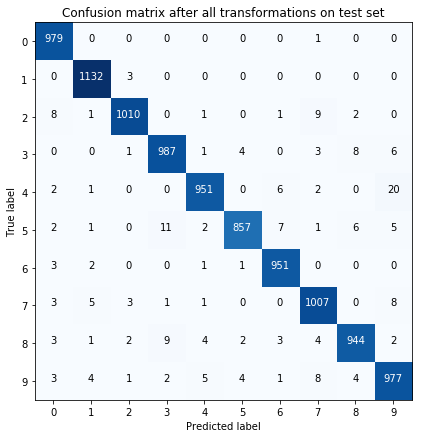

In [454]:
accuracy_fin_test = (pred_fin_test == y_test).sum() / len(y_test)
cm = confusion_matrix(y_test, pred_fin_test)
print("Ammount of misses: ",cm.sum() - np.diag(cm).sum())
print("Accuracy: %0.5f" % accuracy_fin_test)
plt.figure(figsize=(13, 6))
plot_confusion_matrix(cm, classes = np.unique(y_test).astype(int), title='Confusion matrix after all transformations on test set')
plt.savefig("cm_fin_test.pdf", format='pdf', bbox_inches='tight')
plt.show()